# Custom Shazam

## Import dependencies

In [1]:
import os
import hashlib
import librosa
import librosa.display

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.io import wavfile
from pydub import AudioSegment
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (generate_binary_structure, iterate_structure, binary_erosion)

## Download songs

Now we will gather audio data to play with it and get used to it. To download a song just paste the desired youtube link, ```youtube-dl``` will do the magic for you.

In [2]:
SONGS = [
    'https://www.youtube.com/watch?v=FATTzbm78cc',
    'https://www.youtube.com/watch?v=dQw4w9WgXcQ&list=PLahKLy8pQdCM0SiXNn3EfGIXX19QGzUG3',
    'https://www.youtube.com/watch?v=GgwUenaQqlM',
    'https://www.youtube.com/watch?v=M9xMuPWAZW8'
]

In [3]:
import os 
from tqdm import tqdm # for the progress bar

os.makedirs('data', exist_ok=True)

In [4]:
def download_song(i, url):
    os.system(f'youtube-dl -o "./data/{i}.%(ext)s" -x --audio-format mp3 {url}')    
    # youtube-dl -x --audio-format mp3 https://www.youtube.com/watch?v=jwD4AEVBL6Q

    
pbar = tqdm(len(SONGS))
for i, song in enumerate(SONGS):
    download_song(i, song)

0it [00:00, ?it/s]

In [5]:
!ls data

0.mp3  1.mp3  2.mp3  3.mp3


In [6]:
# listen to the song 
from IPython.display import Audio
Audio('data/3.mp3')

## Show spectogram

We know will use librosa to show the spectogram of the downloaded songs.

/home/taro/shazam/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


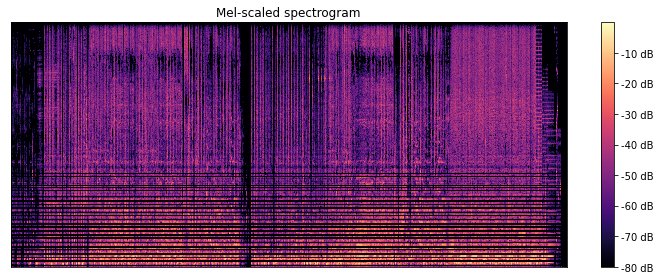

/home/taro/shazam/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


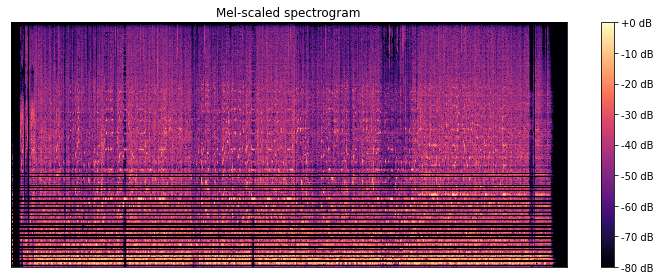

/home/taro/shazam/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


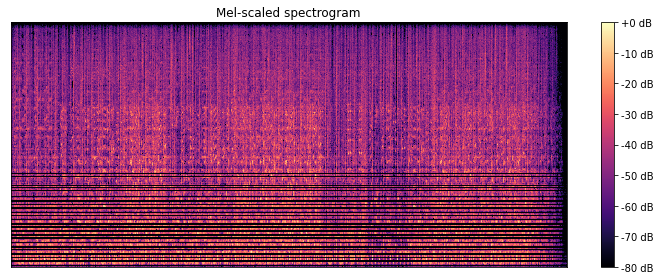

/home/taro/shazam/env/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


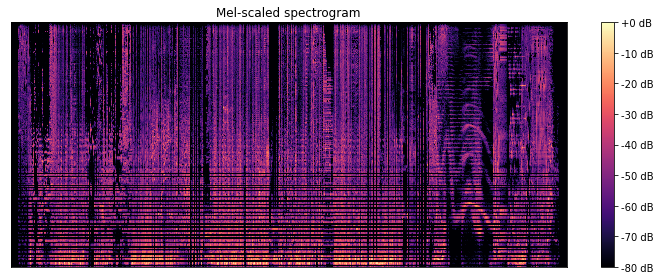

In [7]:
def convert_mp3_to_wav(mp3_file):
    # For this you need to have installed ffmpeg, if you do not have it, convert manually the mp3 to wav
    mp3_audio = AudioSegment.from_file(mp3_file, format="mp3")  # read mp3
    #mp3_audio = mp3_audio[330970:339900] # select some seconds, it is in miliseconds 
    mp3_audio.export('temp.wav', format="wav")  # convert to wav
    
    
def reading_song(mp3_file):
    convert_mp3_to_wav(mp3_file)
    plt.figure(figsize=(10, 4))
    y, sr = librosa.load("temp.wav")
    S= librosa.feature.melspectrogram(y=y, sr=sr, n_mels=1000)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-scaled spectrogram')
    plt.tight_layout()
    plt.show()


for song in os.listdir('./data'):
    reading_song(os.path.join('./data', song))

## Generate hash

Useful links:

- http://coding-geek.com/how-shazam-works/
- https://github.com/itspoma/audio-fingerprint-identifying-python

First we read the audio (it can be more than one channel i.e. stereo) as numpy arrays using the function ```read_values_audio```. Then make the Fast Fourier Transform to each channel using the ```specgram``` function from the matplotlib package. Then we apply the log transform (because the function specgram returns a linear array) and we find local maximas with ```get_2D_peaks```. Finally we return its locally sensitive hashes with ```generate_hashes```.  

In [20]:
def read_audio_values(mp3_file, limit = True):
    audiofile = AudioSegment.from_file(mp3_file)
    if limit:
        audiofile = audiofile[:limit * 1000]
    data = np.fromstring(audiofile._data, np.int16)
    channels = []
    for chn in range(audiofile.channels):
        channels.append(data[chn::audiofile.channels])
    return channels

In [9]:
def get_2D_peaks(arr2D, plot=False, amp_min=10):
    struct = generate_binary_structure(2, 1)
    neighborhood = iterate_structure(struct, 20)

    # find local maxima using our filter shape
    local_max = maximum_filter(arr2D, footprint=neighborhood) == arr2D
    background = (arr2D == 0)
    eroded_background = binary_erosion(background, structure=neighborhood,
                                   border_value=1)

    # Boolean mask of arr2D with True at peaks
    detected_peaks = local_max ^ eroded_background

    # extract peaks
    amps = arr2D[detected_peaks]
    j, i = np.where(detected_peaks)

    # filter peaks
    amps = amps.flatten()
    peaks = zip(i, j, amps)
    peaks_filtered = [x for x in peaks if x[2] > amp_min]  # freq, time, amp

    # get indices for frequency and time
    frequency_idx = [x[1] for x in peaks_filtered]
    time_idx = [x[0] for x in peaks_filtered]

    # scatter of the peaks
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(arr2D)
        ax.scatter(time_idx, frequency_idx)
        ax.set_xlabel('Time')
        ax.set_ylabel('Frequency')
        ax.set_title("Spectrogram")
        plt.gca().invert_yaxis()
        plt.show()

    return zip(frequency_idx, time_idx)

In [11]:
def generate_hashes(peaks, fan_value=15):
    peaks.sort(key=itemgetter(1))

    # bruteforce all peaks
    for i in range(len(peaks)):
        for j in range(1, 15):
            if (i + j) < len(peaks):
                # take current & next peak frequency value
                freq1 = peaks[i][0]
                freq2 = peaks[i + j][0]

                # take current & next -peak time offset
                t1 = peaks[i][1]
                t2 = peaks[i + j][1]

                t_delta = t2 - t1

                # check if delta is between min & max
                if t_delta >= 0 and t_delta <= 200:
                    h = hashlib.sha1("%s|%s|%s" % (str(freq1), str(freq2), str(t_delta)))
                    yield (h.hexdigest()[0:20], t1)

In [22]:
def get_hash(mp3_file): 
    channel_samples = read_audio_values(mp3_file)
    plots = True
     # show samples plot
    if plots:
        plt.plot(channel_samples)
        plt.title('%d samples' % len(channel_samples))
        plt.xlabel('time (s)')
        plt.ylabel('amplitude (A)')
        plt.show()
        plt.gca().invert_yaxis()

    # FFT the channel, log transform output, find local maxima, then return
    # locally sensitive hashes.
    # FFT the signal and extract frequency components
    arr2D = mlab.specgram(
        channel_samples,
        NFFT=4096,
        Fs=44100,
        window=mlab.window_hanning,
        noverlap=int(4096 * 0.5))[0]

    # EXPLAINED VALUES
    # 44100 is the sampling rate, related to the Nyquist conditions, 
    #which affects the range frequencies we can detect.
    # 4096 is the size of the FFT window, affects frequency granularity

    # show spectrogram plot
    if plots:
        plt.plot(arr2D)
        plt.title('FFT')
        plt.show()

    # apply log transform since specgram() returns linear array
    arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D
    arr2D[arr2D == -np.inf] = 0  # replace infs with zeros

    # find local maxima
    local_maxima = get_2D_peaks(arr2D, plot=plots, amp_min=10)
    return generate_hashes(local_maxima)

<ipython-input-20-1ee87b1b64b1>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(audiofile._data, np.int16)


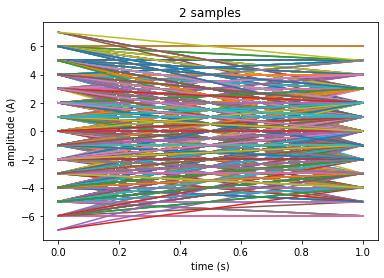

<ipython-input-22-744edf98a6f2>:16: UserWarning: Only one segment is calculated since parameter NFFT (=4096) >= signal length (=2).
  arr2D = mlab.specgram(


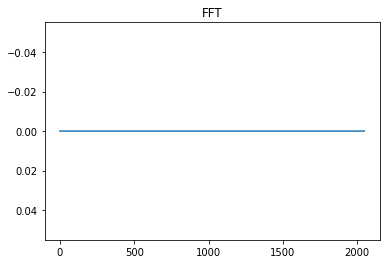

<ipython-input-22-744edf98a6f2>:35: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D


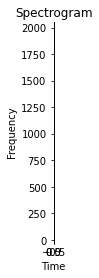

<ipython-input-20-1ee87b1b64b1>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(audiofile._data, np.int16)


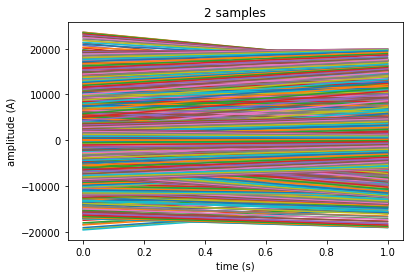

<ipython-input-22-744edf98a6f2>:16: UserWarning: Only one segment is calculated since parameter NFFT (=4096) >= signal length (=2).
  arr2D = mlab.specgram(


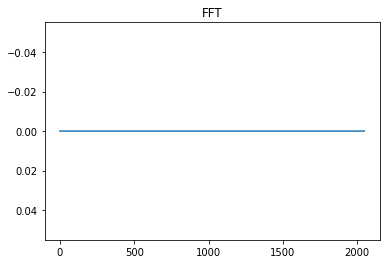

<ipython-input-22-744edf98a6f2>:35: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D


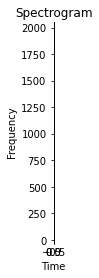

<ipython-input-20-1ee87b1b64b1>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(audiofile._data, np.int16)


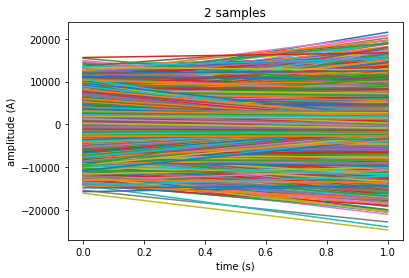

<ipython-input-22-744edf98a6f2>:16: UserWarning: Only one segment is calculated since parameter NFFT (=4096) >= signal length (=2).
  arr2D = mlab.specgram(


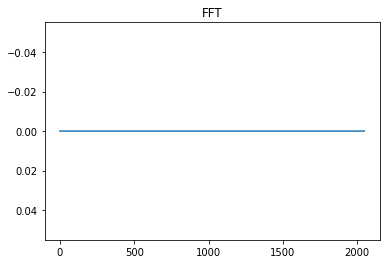

<ipython-input-22-744edf98a6f2>:35: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D


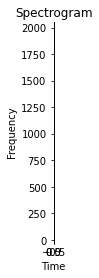

<ipython-input-20-1ee87b1b64b1>:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(audiofile._data, np.int16)


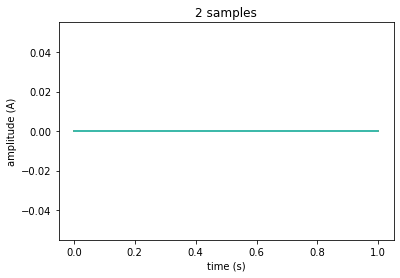

<ipython-input-22-744edf98a6f2>:16: UserWarning: Only one segment is calculated since parameter NFFT (=4096) >= signal length (=2).
  arr2D = mlab.specgram(


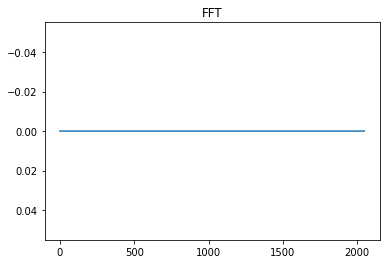

<ipython-input-22-744edf98a6f2>:35: RuntimeWarning: divide by zero encountered in log10
  arr2D = 10 * np.log10(arr2D) # calculates the base 10 logarithm for all elements of arr2D


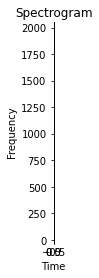

In [23]:
dictionary = {}
for song in os.listdir('./data'):
    key = get_hash(os.path.join('./data', song))
    dictionary[key] = song

In [24]:
print(dictionary)

{<generator object generate_hashes at 0x7fb3c30e9580>: '0.mp3', <generator object generate_hashes at 0x7fb3c92e17b0>: '2.mp3', <generator object generate_hashes at 0x7fb3c52e1660>: '1.mp3', <generator object generate_hashes at 0x7fb3c6194890>: '3.mp3'}
